In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]
    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks
    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks
    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks
    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])
    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""
    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')
    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False
    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    if title:
        plt.title(title)

In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

In [4]:
data = pd.read_csv('boost_models/data/finaldata_w_xy_and_dummies.csv')
data = data.drop(columns='Unnamed: 0')
data.shape

(17639, 54)

In [5]:
data.columns

Index(['gameId', 'playId', 'x', 'y', 'nflId', 'event', 'displayName',
       'frameId', 'targetNflId', 'Opp_Dist', 'closestOpp_Id', 'Team_Dist',
       'closestTeam_Id', 'QB_Dist', 'closestQB_Id', 'FootDist', 'quarter',
       'down', 'yardsToGo', 'defendersInTheBox', 'numberOfPassRushers',
       'absoluteYardlineNumber', 'passResult', 'penalty', 'offensePlayResult',
       'epa', 'playResult', 'isDefensivePI', 'height', 'weight', 'position_CB',
       'position_DB', 'position_DE', 'position_DT', 'position_FB',
       'position_HB', 'position_K', 'position_QB', 'position_RB',
       'position_TE', 'position_WR', 'route_ANGLE', 'route_CORNER',
       'route_CROSS', 'route_FLAT', 'route_GO', 'route_HITCH', 'route_IN',
       'route_OUT', 'route_POST', 'route_SCREEN', 'route_SLANT', 'route_WHEEL',
       'route_undefined'],
      dtype='object')

In [6]:
df = data[['passResult','quarter','down','yardsToGo','Opp_Dist','Team_Dist','QB_Dist','FootDist',\
           'defendersInTheBox','numberOfPassRushers','height','weight','position_CB', 'position_DB', \
           'position_DE', 'position_DT','position_FB', 'position_HB', 'position_K', 'position_QB', \
           'position_RB', 'position_TE', 'position_WR', 'route_ANGLE','route_CORNER', 'route_CROSS', \
           'route_FLAT', 'route_GO', 'route_HITCH', 'route_IN', 'route_OUT', 'route_POST', \
           'route_SCREEN', 'route_SLANT','route_WHEEL',]]
df.shape

(17639, 35)

In [7]:
# format heigh to number in inches
height_dict = {'5-10':70,'6-5':77, '6-4':76, '6-3':75, '6-2':74, '6-1':73, '6-0':72, '5-11':71, \
               '5-9':69, '5-8':68, '5-7':67, '5-6':66,'6-7':79,'6-6':78,'64':64,'65':65,'66':66,'67':67,'68':68, \
              '69':69,'70':70,'71':71,'72':72,'73':73,'74':74,'75':75,'76':76,'77':77,'78':78,'79':79,'80':80}
df['height'] = data['height'].map(height_dict) 
df.shape

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(17639, 35)

In [8]:
df.dropna()
df.shape

(17639, 35)

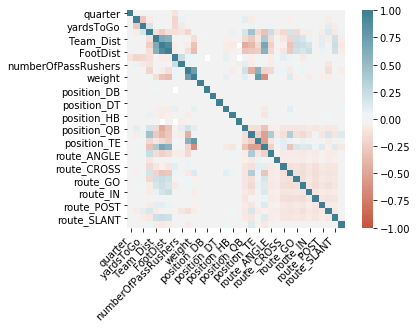

In [9]:
corr = df.drop(['passResult'], axis=1).corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [10]:
# Split data into train, validation, test
X = df.drop(['passResult'], axis=1)
y = df['passResult']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, shuffle=True, random_state=42)

feature_names = X.columns
X_train = pd.DataFrame(data=X_train, columns=feature_names)
X_val = pd.DataFrame(data=X_val, columns=feature_names)

print('Train observations: ',len(X_train))
print('Validation observations: ',len(X_val))
print('Test observations: ',len(X_test))

Train observations:  9921
Validation observations:  3308
Test observations:  4410


In [16]:
clf = XGBClassifier(n_estimators=1000, random_state=42,
                     booster='gbtree', objective='binary:logistic',
                      eval_metric = ["auc","error"],
                     colsample_bylevel=1,
                     colsample_bytree=1,
                     gamma=5,
                     learning_rate=0.3,
                      max_depth=6,
                      min_child_weight=1,
                      subsample=1
                     )

clf.fit(X_train, y_train, early_stopping_rounds=50,
          eval_set=[(X_val, y_val)])

y_pred = clf.predict(X_test)

[0]	validation_0-auc:0.70810	validation_0-error:0.28053
Multiple eval metrics have been passed: 'validation_0-error' will be used for early stopping.

Will train until validation_0-error hasn't improved in 50 rounds.
[1]	validation_0-auc:0.72811	validation_0-error:0.28597
[2]	validation_0-auc:0.73429	validation_0-error:0.28628
[3]	validation_0-auc:0.73862	validation_0-error:0.28567
[4]	validation_0-auc:0.73808	validation_0-error:0.28386
[5]	validation_0-auc:0.73997	validation_0-error:0.28507
[6]	validation_0-auc:0.73977	validation_0-error:0.28174
[7]	validation_0-auc:0.73991	validation_0-error:0.28053
[8]	validation_0-auc:0.73944	validation_0-error:0.28053
[9]	validation_0-auc:0.74036	validation_0-error:0.28174
[10]	validation_0-auc:0.74011	validation_0-error:0.27993
[11]	validation_0-auc:0.73874	validation_0-error:0.28144
[12]	validation_0-auc:0.73958	validation_0-error:0.28083
[13]	validation_0-auc:0.73959	validation_0-error:0.28174
[14]	validation_0-auc:0.74000	validation_0-error:0.

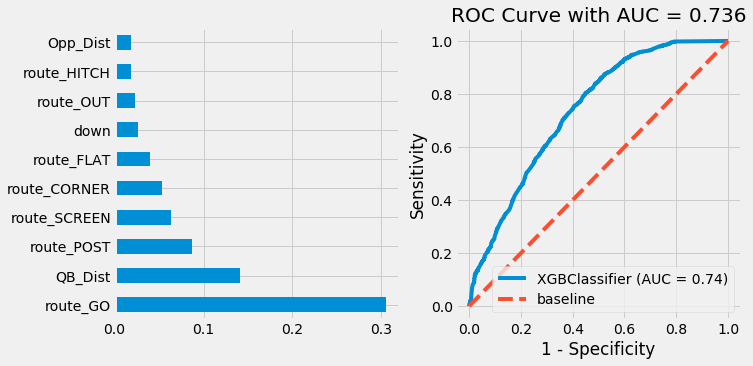

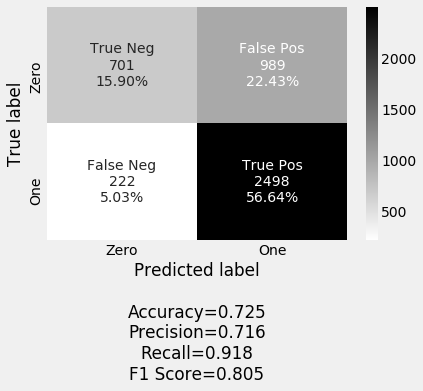

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
plt.style.use('fivethirtyeight')

# Create and fit selector
feat = df.drop(columns='passResult')
feat_importances = pd.Series(clf.feature_importances_, index=feat.columns)
feat_importances.nlargest(10).plot(kind='barh',ax=ax1)

plot_roc_curve(clf, X_test, y_test, ax=ax2)
# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

score = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

# Label axes.
plt.title(f"ROC Curve with AUC = {round(score,3)}")
plt.ylabel('Sensitivity')
plt.xlabel('1 - Specificity')
# Create legend.
plt.legend();
plt.subplots_adjust(hspace = .5)


cm = confusion_matrix(y_test, y_pred)

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']

make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

In [18]:
from sklearn.metrics import accuracy_score
baseline = (y_test == 1).sum()/len(y_test)
accuracy = accuracy_score(y_test, y_pred)
print('Baseline accuracy score: {0:0.4f}'. format(baseline))
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print('Percent improvement: {0:0.4f}'. format(accuracy-baseline))

Baseline accuracy score: 0.6168
XGBoost model accuracy score: 0.7254
Percent improvement: 0.1086


In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.41      0.54      1690
           1       0.72      0.92      0.80      2720

    accuracy                           0.73      4410
   macro avg       0.74      0.67      0.67      4410
weighted avg       0.73      0.73      0.70      4410



In [20]:
feat_importances.sort_values(ascending=False)

route_GO               0.304898
QB_Dist                0.140870
route_POST             0.087166
route_SCREEN           0.062989
route_CORNER           0.053071
route_FLAT             0.039752
down                   0.026377
route_OUT              0.022816
route_HITCH            0.018611
Opp_Dist               0.018428
position_RB            0.018083
FootDist               0.018067
route_WHEEL            0.017861
position_TE            0.016871
numberOfPassRushers    0.015776
weight                 0.015477
yardsToGo              0.015321
Team_Dist              0.015038
route_CROSS            0.014939
height                 0.014862
position_HB            0.014613
route_SLANT            0.013893
quarter                0.012320
defendersInTheBox      0.012061
route_IN               0.009842
position_DB            0.000000
position_CB            0.000000
position_DE            0.000000
position_DT            0.000000
position_FB            0.000000
position_K             0.000000
position

In [17]:
#Accuracy = (TP + TN) / All Predictions

# Mis-Classification is (1-Accuracy), and means all false predictions over the total number of predictions.

# Sensitivity (aka Recall) means “out of all actual Positives, how many did we predict as Positive”, 
# which can be explained as:
# Sensitivity (Recall) = TP / (FN + TP)

# Specificity (aka Selectivity or True Negative Rate, TNR) means “out of all actual Negatives,
# how many did we predict as Negative”, and can be written as:
# Specificity = TN / (TN + FP)

# Precision (aka Positive Predictive Value, PPV) means “out of all predicted Positive cases,
# how many were actually Positive”, or
# Precision = TP / (TP + FP)

# F1 Score is the harmonic, or weighted, an average of Precision and Sensitivity, 
# and is a widely used measure of accuracy for classification problems. It is calculated as:
# F1 Score = 2 * (Precision * Sensitivity) / (Precision + Sensitivity)

We see unless you are lining up in the backfield (you're a running back/half back or tight end) having a position, doesn't matter at all. It makes sense we're seeing that being a RB/HB or TE's is important because the second more important feature is starting distance from the quarterback.

Now I'll run the model again with only the 10 best features

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_sc = pd.DataFrame(scaler.fit_transform(X), index = X.index, columns = X.columns)

cols = feat_importances.sort_values(ascending=False).index[:10].tolist()
X_train_val, X_test, y_train_val, y_test = train_test_split(X_sc[cols], y, test_size=0.25, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, shuffle=True, random_state=42)

In [22]:
clf2 = XGBClassifier(n_estimators=1000, random_state=42,
                     booster='gbtree', objective='binary:logistic',
                      eval_metric = ["auc","error"],
                     colsample_bylevel=1,
                     colsample_bytree=1,
                     gamma=5,
                     learning_rate=0.1,
                      max_depth=5,
                      min_child_weight=1,
                      subsample=1
                     )

clf2.fit(X_train, y_train, early_stopping_rounds=50,
          eval_set=[(X_val, y_val)])
y_pred2 = clf2.predict(X_test)


[0]	validation_0-auc:0.70159	validation_0-error:0.28356
Multiple eval metrics have been passed: 'validation_0-error' will be used for early stopping.

Will train until validation_0-error hasn't improved in 50 rounds.
[1]	validation_0-auc:0.72193	validation_0-error:0.28779
[2]	validation_0-auc:0.72993	validation_0-error:0.28658
[3]	validation_0-auc:0.73102	validation_0-error:0.28658
[4]	validation_0-auc:0.73574	validation_0-error:0.28628
[5]	validation_0-auc:0.73346	validation_0-error:0.28658
[6]	validation_0-auc:0.73711	validation_0-error:0.28628
[7]	validation_0-auc:0.73713	validation_0-error:0.28628
[8]	validation_0-auc:0.73677	validation_0-error:0.28628
[9]	validation_0-auc:0.73922	validation_0-error:0.28567
[10]	validation_0-auc:0.73951	validation_0-error:0.28567
[11]	validation_0-auc:0.74009	validation_0-error:0.28567
[12]	validation_0-auc:0.74122	validation_0-error:0.28567
[13]	validation_0-auc:0.74095	validation_0-error:0.28567
[14]	validation_0-auc:0.74116	validation_0-error:0.

In [39]:
## # SVC
from sklearn.svm import SVC
svc1 = SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
svc1.fit(X_train1, y_train1)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [40]:
### RF
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 180, max_features ='sqrt')
rfc.fit(X_train1, y_train1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=180,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

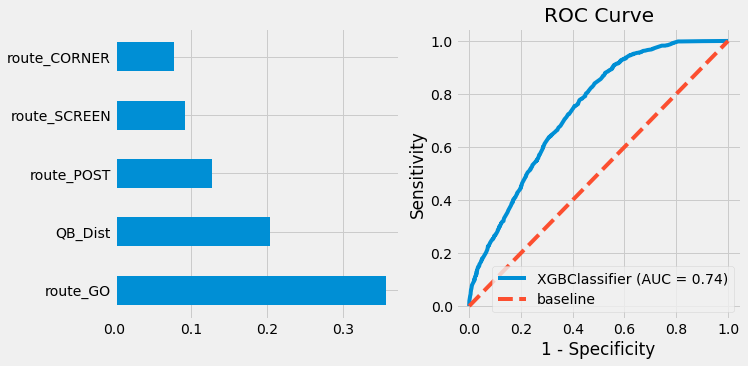

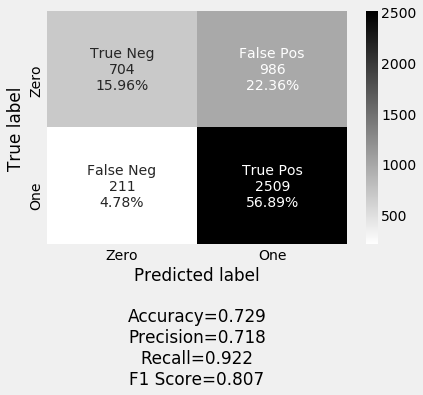

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
plt.style.use('fivethirtyeight')

# Create and fit selector
features = X[cols]
feat_importances = pd.Series(clf2.feature_importances_, index=features.columns)
feat_importances.nlargest(5).plot(kind='barh',ax=ax1)

plot_roc_curve(clf2, X_test, y_test, ax=ax2)
#ax2 = plot_roc_curve(reg, X_test1, y_test1)
#plot_roc_curve(clf2, X_test, y_test, ax=ax2.ax_)
#plot_roc_curve(svc1, X_test1, y_test1, ax=ax2.ax_)
#plot_roc_curve(rfc, X_test1, y_test1, ax=ax2.ax_)


# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

score = roc_auc_score(y_test, clf2.predict_proba(X_test)[:,1])

# Label axes.
plt.title(f"ROC Curve")
plt.ylabel('Sensitivity')
plt.xlabel('1 - Specificity')
# Create legend.
plt.legend();
plt.subplots_adjust(hspace = .5)


cm = confusion_matrix(y_test, y_pred2)

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']

make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

In [25]:
roc_auc_score(y_test, clf2.predict_proba(X_test)[:,1])

0.7374984772015315

In [26]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred2)

0.8074014481094126

In [27]:
from sklearn.metrics import accuracy_score
baseline = (y_test == 1).sum()/len(y_test)
accuracy = accuracy_score(y_test, y_pred2)
print('Baseline accuracy score: {0:0.4f}'. format(baseline))
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred2)))
print('Percent improvement: {0:0.4f}'. format(accuracy-baseline))

Baseline accuracy score: 0.6168
XGBoost model accuracy score: 0.7286
Percent improvement: 0.1118


In [ ]:
import graphviz
from xgboost import plot_tree
import matplotlib.pyplot as plt

# plot single tree
xgb.to_graphviz(clf2,rankdir='LR',num_trees=33,**{'size':str(10)})

In [ ]:
(1/(1+np.exp(0.00785947125)))

#### We see some slight improvement

### Let's try k-fold cross validation with XGB

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
from xgboost import cv

params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}


xgb_cv = cv(dtrain=dtrain, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=42)
xgb_cv.head()

In [331]:
from scipy import stats
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import f1_score

clf_xgb = XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': stats.randint(150, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }

clf3 = RandomizedSearchCV(clf_xgb, param_distributions = param_dist, n_iter = 25, scoring = 'f1', random_state = 42, error_score = 0, verbose = 3, n_jobs = -1)

numFolds = 5
folds = KFold(n_splits = numFolds, shuffle = True)

estimators = []
results = np.zeros(len(X))
score = 0.0
for train_index, test_index in folds.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    clf3.fit(X_train, y_train)

    estimators.append(clf3.best_estimator_)
    results[test_index] = clf3.predict(X_test)
    score += f1_score(y_test, results[test_index])
score /= numFolds

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 10.6min finished


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  9.7min finished


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  7.9min finished


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 11.1min finished


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 10.4min finished


In [ ]:
accuracy_score(y_test, results[test_index])

In [ ]:
score

In [334]:
estimators

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.7925611896508273, gamma=0,
               gpu_id=-1, importance_type='gain', interaction_constraints='',
               learning_rate=0.02395024509413899, max_delta_step=0, max_depth=3,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=256, n_jobs=0, num_parallel_tree=1,
               objective='binary:logistic', random_state=0, reg_alpha=0,
               reg_lambda=1, scale_pos_weight=1, subsample=0.8993324419915627,
               tree_method='exact', validate_parameters=1, verbosity=None),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.6200030536160359, gamma=0,
               gpu_id=-1, importance_type='gain', interaction_constraints='',
               learning_rate=0.02321976570056989, max_delta_step=0, max_depth=6,
             

In [ ]:
models = []

# CLASSIFICATION
models.append(('SVM', svm.SVC()))
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

# REGRESSION

#models.append(('SGDRegressor', linear_model.SGDRegressor())) #ValueError: Classification metrics can't handle a mix of binary and continuous targets
#models.append(('BayesianRidge', linear_model.BayesianRidge())) #ValueError: Classification metrics can't handle a mix of binary and continuous targets
#models.append(('LassoLars', linear_model.LassoLars())) #ValueError: Classification metrics can't handle a mix of binary and continuous targets
#models.append(('ARDRegression', linear_model.ARDRegression())) #ValueError: Classification metrics can't handle a mix of binary and continuous targets
#models.append(('PassiveAggressiveRegressor', linear_model.PassiveAggressiveRegressor())) #ValueError: Classification metrics can't handle a mix of binary and continuous targets
#models.append(('TheilSenRegressor', linear_model.TheilSenRegressor())) #ValueError: Classification metrics can't handle a mix of binary and continuous targets
#models.append(('LinearRegression', linear_model.LinearRegression())) #ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [32]:
falses = X_train[(X_train['QB_Dist'].isnull() == True) | (X_train['defendersInTheBox'].isnull() == True)]
false_test = X_test[(X_test['QB_Dist'].isnull() == True) | (X_test['defendersInTheBox'].isnull() == True)]


idx = falses.index
idx_test = false_test.index

X_train1 = X_train
X_test1 = X_test
y_train1 = y_train
y_test1 = y_test


X_train1.dropna(subset=['QB_Dist', 'defendersInTheBox'], inplace=True)
X_test1.dropna(subset=['QB_Dist', 'defendersInTheBox'], inplace=True)
y_train1.drop(index=idx, inplace=True)
y_test1.drop(index=idx_test, inplace=True)


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [33]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, plot_roc_curve, f1_score
from matplotlib import pyplot as plt

reg = MLPClassifier(shuffle=True, max_iter=500, early_stopping=True).fit(X_train1, y_train1)

pred = reg.predict(X_test1)
probabs = reg.predict_proba(X_test1)[:,1]

print(accuracy_score(y_test1, pred), roc_auc_score(y_test1, probabs), f1_score(y_test1, pred))

0.7257881605806306 0.7429948358145942 0.8001983143282103


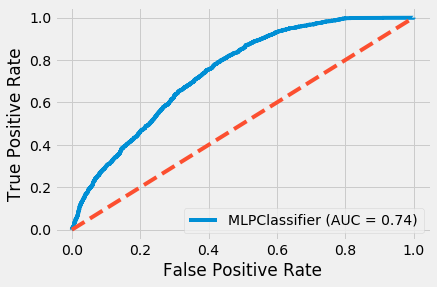

In [34]:
plot_roc_curve(reg, X_test1, y_test1)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

XGBoostError: [22:13:13] /Users/travis/build/dmlc/xgboost/src/learner.cc:1117: Check failed: learner_model_param_.num_feature >= p_fmat->Info().num_col_ (10 vs. 34) : Number of columns does not match number of features in booster.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000001a1442ea60 dmlc::LogMessageFatal::~LogMessageFatal() + 112
  [bt] (1) 2   libxgboost.dylib                    0x0000001a144e6107 xgboost::LearnerImpl::ValidateDMatrix(xgboost::DMatrix*, bool) const + 503
  [bt] (2) 3   libxgboost.dylib                    0x0000001a144e6215 xgboost::LearnerImpl::PredictRaw(xgboost::DMatrix*, xgboost::PredictionCacheEntry*, bool, unsigned int) const + 69
  [bt] (3) 4   libxgboost.dylib                    0x0000001a144d60d7 xgboost::LearnerImpl::Predict(std::__1::shared_ptr<xgboost::DMatrix>, bool, xgboost::HostDeviceVector<float>*, unsigned int, bool, bool, bool, bool, bool) + 743
  [bt] (4) 5   libxgboost.dylib                    0x0000001a14426d6a XGBoosterPredict + 266
  [bt] (5) 6   libffi.6.dylib                      0x0000000102eda884 ffi_call_unix64 + 76



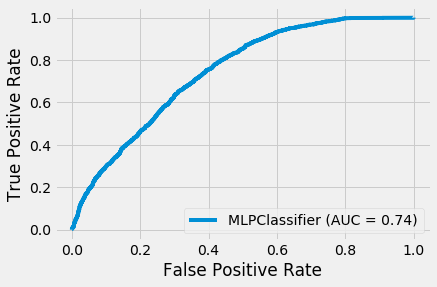

In [35]:
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

disp = plot_roc_curve(reg, X_test1, y_test1)
plot_roc_curve(clf2, X_test, y_test, ax=disp.ax_)
#plot_roc_curve(clf2, X_test_clean2, y_test, ax=disp.ax_)
#plot_roc_curve(clf3, X_test_clean3, y_test, ax=disp.ax_)
#plot_roc_curve(clf4, X_test_clean4, y_test, ax=disp.ax_)
#plt.legend(['160 features','100 features','30 features','10 features'])